# Explainability of Neural Network Models for Time Series

## Notebook Overview
The aim is to identify and quantify the most relevant input features influencing model performance.

## Imports

In [2]:
import pandas as pd
import numpy as np
import sys
import os
# Getting src path to import modules
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))

# Adding src path to the system path, if not already added
if src_path not in sys.path:
    sys.path.append(src_path)

from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from dl_models import AutoencoderKfold as ae
from dl_models import LSTMKfold as lstm
from dl_models import AutoencoderLSTMKfold as ael
from utils import plots as plts
from utils import importance as im

In [3]:
# Time series data for all buildings
building_1_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/Building_1.csv")
building_2_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/Building_2.csv")
building_3_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/Building_3.csv")

# Carbon intensity data.
carbon_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/carbon_intensity.csv")

# Pricing data.
pricing_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/pricing.csv")

# Weather data.
weather_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/weather.csv")

# Target features to forecast
targets = ['cooling_demand', 'carbon_intensity', 'solar_generation']

# List of features used for training the autoencoder.
features = ['month', 'hour', 'day_type', 'daylight_savings_status', 'indoor_dry_bulb_temperature', 'average_unmet_cooling_setpoint_difference', 
            'indoor_relative_humidity', 'non_shiftable_load', 'dhw_demand', 'cooling_demand', 'heating_demand', 'solar_generation', 'occupant_count', 
            'indoor_dry_bulb_temperature_set_point', 'hvac_mode', 'carbon_intensity', 'electricity_pricing', 
            'electricity_pricing_predicted_6h', 'electricity_pricing_predicted_12h', 'electricity_pricing_predicted_24h', 
            'outdoor_dry_bulb_temperature', 'outdoor_relative_humidity', 'diffuse_solar_irradiance', 'direct_solar_irradiance', 
            'outdoor_dry_bulb_temperature_predicted_6h', 'outdoor_dry_bulb_temperature_predicted_12h', 'outdoor_dry_bulb_temperature_predicted_24h', 
            'outdoor_relative_humidity_predicted_6h', 'outdoor_relative_humidity_predicted_12h', 'outdoor_relative_humidity_predicted_24h', 
            'diffuse_solar_irradiance_predicted_6h', 'diffuse_solar_irradiance_predicted_12h', 'diffuse_solar_irradiance_predicted_24h', 
            'direct_solar_irradiance_predicted_6h', 'direct_solar_irradiance_predicted_12h', 'direct_solar_irradiance_predicted_24h']


df1 = pd.concat([building_1_data, carbon_data, pricing_data, weather_data], axis=1)
# Concatenate the data from Building 2 and Building 3 vertically, creating a unified dataset for evaluation
building_2_3_data = pd.concat([building_2_data, building_3_data], axis=0, ignore_index=True)

# Combine carbon intensity, pricing, and weather data horizontally to align with building data
external_data = pd.concat([carbon_data, pricing_data, weather_data], axis=1)

# Repeat the external data (carbon, pricing, weather) to match the number of rows in Building 2 and 3 data
external_data_repeated = pd.concat([external_data] * 2, axis=0, ignore_index=True)

X_train = df1
X_test = pd.concat([building_2_3_data, external_data_repeated], axis=1)

scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler.fit_transform(X_train[features].values)
X_test_scaled = scaler.transform(X_test[features].values)

## Phase 1: Identifying Important Features
- Use the Autoencoder-LSTM model from the evaluation notebooks to evaluate the full set of input features.
- Compute Permutation Feature Importance (PFI) by measuring the increase in prediction or reconstruction error when each feature is randomly permuted. Ensure that the target variable for each model is excluded from the feature set when calculating importance, to avoid artificially inflating its contribution. Repeat this procedure separately for each target variable if multiple targets are present.
- Visualize the feature importance using horizontal bar plots, showing the mean and standard deviation of error increases. Normalize values relative to the maximum to facilitate comparison of the relative contribution of each feature.

In [3]:
def create_lstm_input(data, timesteps):
    X_seq = []
    for i in range(len(data) - timesteps + 1):
        X_seq.append(data[i:i+timesteps])
    return np.array(X_seq)

In [4]:
real_ael, pred_ael, model_ael = ael.Autoencoder(train_df=X_train, test_df=X_test, features=features, epochs = 300, batch_size = 32, latent_dim = 64, timesteps = 6)

Epoch 1/300
23/23 [==============================] - 3s 32ms/step - loss: 0.1572
Epoch 2/300
23/23 [==============================] - 1s 32ms/step - loss: 0.0740
Epoch 3/300
23/23 [==============================] - 1s 35ms/step - loss: 0.0429
Epoch 4/300
23/23 [==============================] - 1s 39ms/step - loss: 0.0286
Epoch 5/300
23/23 [==============================] - 1s 33ms/step - loss: 0.0235
Epoch 6/300
23/23 [==============================] - 1s 32ms/step - loss: 0.0207
Epoch 7/300
23/23 [==============================] - 1s 31ms/step - loss: 0.0189
Epoch 8/300
23/23 [==============================] - 1s 40ms/step - loss: 0.0175
Epoch 9/300
23/23 [==============================] - 1s 34ms/step - loss: 0.0166
Epoch 10/300
23/23 [==============================] - 1s 41ms/step - loss: 0.0159
Epoch 11/300
23/23 [==============================] - 1s 35ms/step - loss: 0.0151
Epoch 12/300
23/23 [==============================] - 1s 40ms/step - loss: 0.0145
Epoch 13/300
23/23 [=====

In [5]:
timesteps = 6
X_test_seq = create_lstm_input(X_test_scaled, timesteps=timesteps)
means_ael, stds_ael = im.importance_autoencoder_lstm(model_ael, X_test_seq, features)
sorted_idx_ael = np.argsort(means_ael)

45/45 [==============================] - 0s 4ms/step


In [6]:
features_per_target = []
for i, target in enumerate(targets):
    features_per_target.append([f for f in features if f != target])

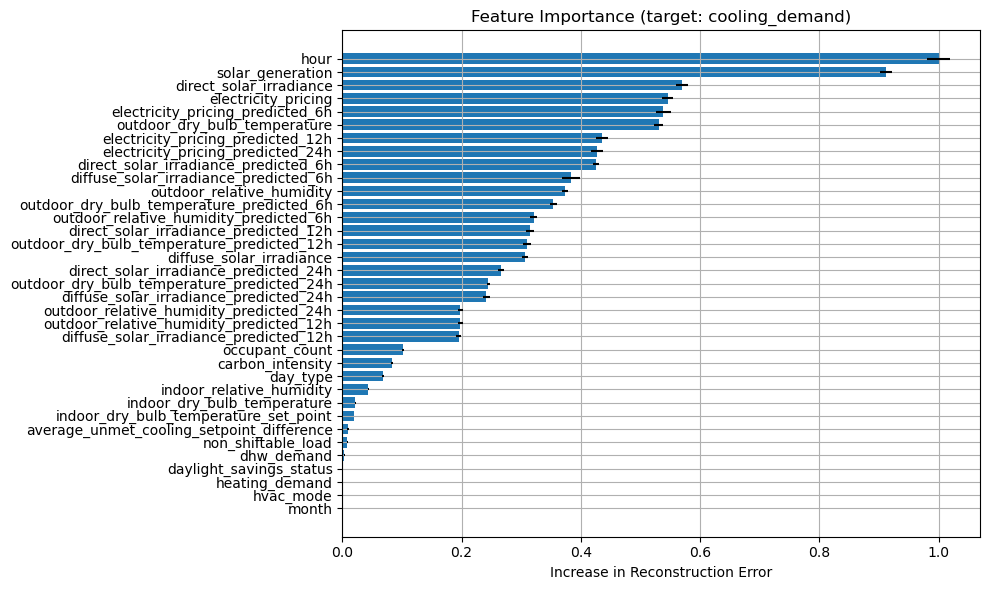

In [8]:
feat_indices = [features.index(f) for f in features_per_target[0]]
means_filtered_0 = means_ael[feat_indices]
stds_filtered_0 = stds_ael[feat_indices]
plts.plot_feature_importance(features_per_target[0], means_filtered_0, stds_filtered_0, title="Feature Importance (target: cooling_demand)", filename="cooling_demand_importance.png")

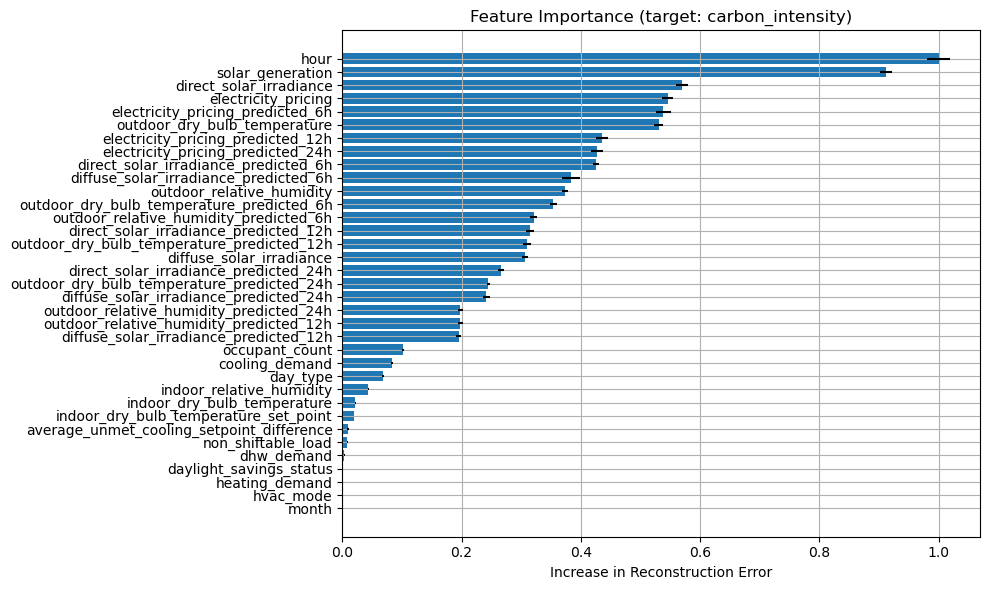

In [9]:
feat_indices = [features.index(f) for f in features_per_target[1]]
means_filtered_1 = means_ael[feat_indices]
stds_filtered_1 = stds_ael[feat_indices]
plts.plot_feature_importance(features_per_target[1], means_filtered_1, stds_filtered_1, title="Feature Importance (target: carbon_intensity)", filename="carbon_intensity_importance.png")

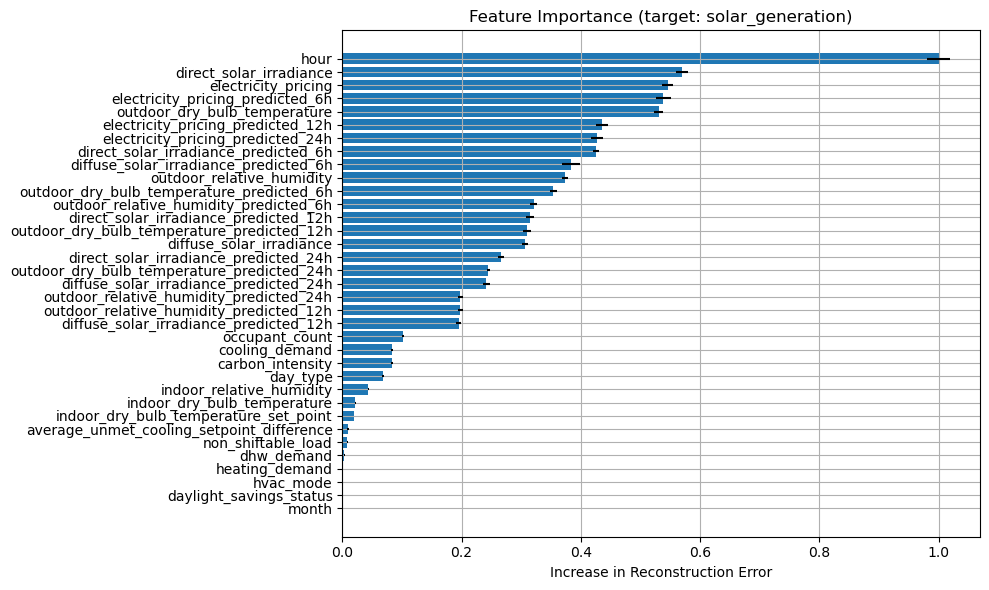

In [10]:
feat_indices = [features.index(f) for f in features_per_target[2]]
means_filtered_2 = means_ael[feat_indices]
stds_filtered_2 = stds_ael[feat_indices]
plts.plot_feature_importance(features_per_target[2], means_filtered_2, stds_filtered_2, title="Feature Importance (target: solar_generation)", filename="solar_generation_importance.png")

## Phase 2: Training on Relevant Features
- Select features in the top quartile (Q3–Q4) for each target and merge them into a single set of relevant features.
- Add all target variables to this set.
- Retrain the Autoencoder-LSTM model on the reduced dataset containing the combined top features.

In [11]:
q3 = np.percentile(means_ael, 75)
selected_features_0 = [f for f, m in zip(features, means_filtered_0) if m >= q3]
selected_features_1 = [f for f, m in zip(features, means_filtered_1) if m >= q3]
selected_features_2 = [f for f, m in zip(features, means_filtered_2) if m >= q3]
top_features = set(selected_features_0 + selected_features_1 + selected_features_2)

top_features.update(targets)

X_train_top = X_train[list(top_features)].copy()
X_test_top = X_test[list(top_features)].copy()

In [12]:
list(top_features)

['solar_generation',
 'diffuse_solar_irradiance',
 'electricity_pricing_predicted_6h',
 'heating_demand',
 'diffuse_solar_irradiance_predicted_24h',
 'electricity_pricing_predicted_12h',
 'cooling_demand',
 'hour',
 'electricity_pricing',
 'electricity_pricing_predicted_24h',
 'carbon_intensity']

In [13]:
real_ael, pred_ael, model_ael = ael.Autoencoder(train_df=X_train_top, test_df=X_test_top, features=list(top_features), epochs = 300, batch_size = 32, latent_dim = 64, timesteps = 6)

Epoch 1/300
23/23 [==============================] - 2s 36ms/step - loss: 0.1047
Epoch 2/300
23/23 [==============================] - 1s 37ms/step - loss: 0.0618
Epoch 3/300
23/23 [==============================] - 1s 36ms/step - loss: 0.0471
Epoch 4/300
23/23 [==============================] - 1s 35ms/step - loss: 0.0350
Epoch 5/300
23/23 [==============================] - 1s 36ms/step - loss: 0.0291
Epoch 6/300
23/23 [==============================] - 1s 35ms/step - loss: 0.0257
Epoch 7/300
23/23 [==============================] - 1s 34ms/step - loss: 0.0230
Epoch 8/300
23/23 [==============================] - 1s 33ms/step - loss: 0.0209
Epoch 9/300
23/23 [==============================] - 1s 30ms/step - loss: 0.0190
Epoch 10/300
23/23 [==============================] - 1s 30ms/step - loss: 0.0176
Epoch 11/300
23/23 [==============================] - 1s 35ms/step - loss: 0.0162
Epoch 12/300
23/23 [==============================] - 1s 29ms/step - loss: 0.0148
Epoch 13/300
23/23 [=====

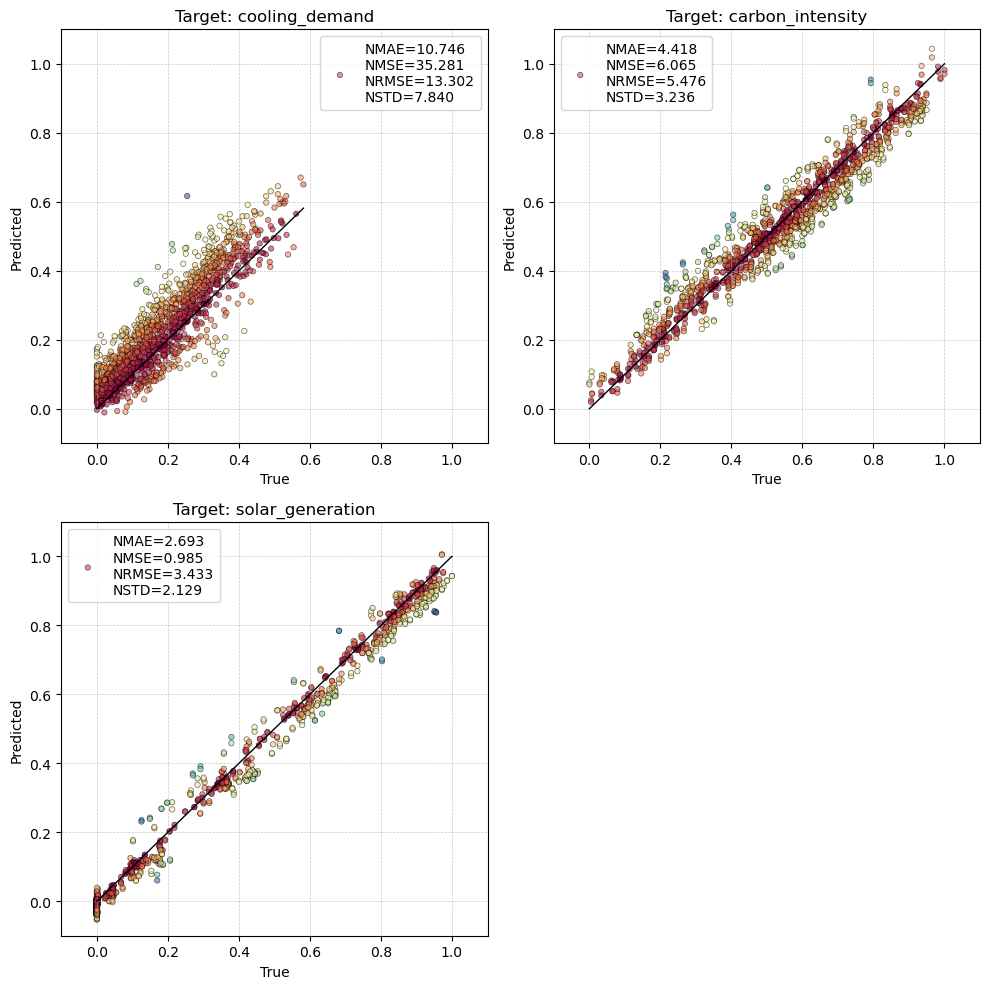

In [14]:
plts.plot_aelstm_targets(real_ael, pred_ael, targets, list(top_features), percent=True, filename="autoencoderLSTM_relevant.png")

## Extra: Recursive Feature Elimination with Cross Validation (RFECV)

RFECV will be applied as an additional feature selection method.  
A baseline model is used to iteratively remove the least important features, while cross validation evaluates model performance at each step.  

**Outputs**  
- Optimal number of features.  
- Selected feature subset.  
- Performance curve vs. number of features.

**Integration**  
The selected features will be used to build reduced datasets and retrain the main models, enabling performance comparison with the full feature set.

In [4]:
estimator = RandomForestRegressor(n_estimators=100, random_state=42)
cv = TimeSeriesSplit(n_splits=5)

rfecv = RFECV(
    estimator=estimator,
    step=1,
    cv=cv,
    scoring="neg_mean_squared_error", 
    n_jobs=-1
)

X_train_ = X_train.drop(columns=targets)
y_train_ = X_train[targets] 

In [5]:
rfecv.fit(X_train_, y_train_)

RFECV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
      estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
      scoring='neg_mean_squared_error')

In [6]:
print("Optimal number of features:", rfecv.n_features_)
print("Selected features:", list(X_train_.columns[rfecv.support_]))

Optimal number of features: 7
Selected features: ['hour', 'outdoor_dry_bulb_temperature', 'outdoor_relative_humidity', 'diffuse_solar_irradiance', 'direct_solar_irradiance', 'diffuse_solar_irradiance_predicted_12h', 'direct_solar_irradiance_predicted_12h']


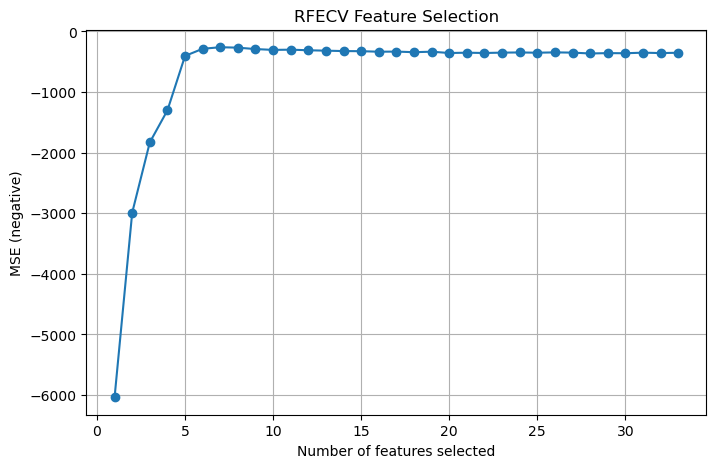

In [7]:
plts.plot_rfecv(rfecv, filename="rfecv.png") # RFECV expects higher scores to be better, so we use negative MSE.

In [8]:
selected_features_rfecv = list(X_train_.columns[rfecv.support_])
for t in targets:
    if t not in selected_features_rfecv:
        selected_features_rfecv.append(t)
X_train_rfecv = X_train.loc[:, selected_features_rfecv].copy()
X_test_rfecv = X_test.loc[:, selected_features_rfecv].copy()

In [9]:
real_ael_rfecv, pred_ael_rfecv, model_ael_rfecv = ael.Autoencoder(train_df=X_train_rfecv, test_df=X_test_rfecv, features=selected_features_rfecv, epochs = 300, batch_size = 32, latent_dim = 64, timesteps = 6)

Epoch 1/300
23/23 [==============================] - 3s 36ms/step - loss: 0.1525
Epoch 2/300
23/23 [==============================] - 1s 37ms/step - loss: 0.0687
Epoch 3/300
23/23 [==============================] - 1s 38ms/step - loss: 0.0440
Epoch 4/300
23/23 [==============================] - 1s 34ms/step - loss: 0.0296
Epoch 5/300
23/23 [==============================] - 1s 36ms/step - loss: 0.0217
Epoch 6/300
23/23 [==============================] - 1s 28ms/step - loss: 0.0160
Epoch 7/300
23/23 [==============================] - 1s 31ms/step - loss: 0.0127
Epoch 8/300
23/23 [==============================] - 1s 37ms/step - loss: 0.0108
Epoch 9/300
23/23 [==============================] - 1s 35ms/step - loss: 0.0094
Epoch 10/300
23/23 [==============================] - 1s 38ms/step - loss: 0.0086
Epoch 11/300
23/23 [==============================] - 1s 32ms/step - loss: 0.0080
Epoch 12/300
23/23 [==============================] - 1s 34ms/step - loss: 0.0076
Epoch 13/300
23/23 [=====

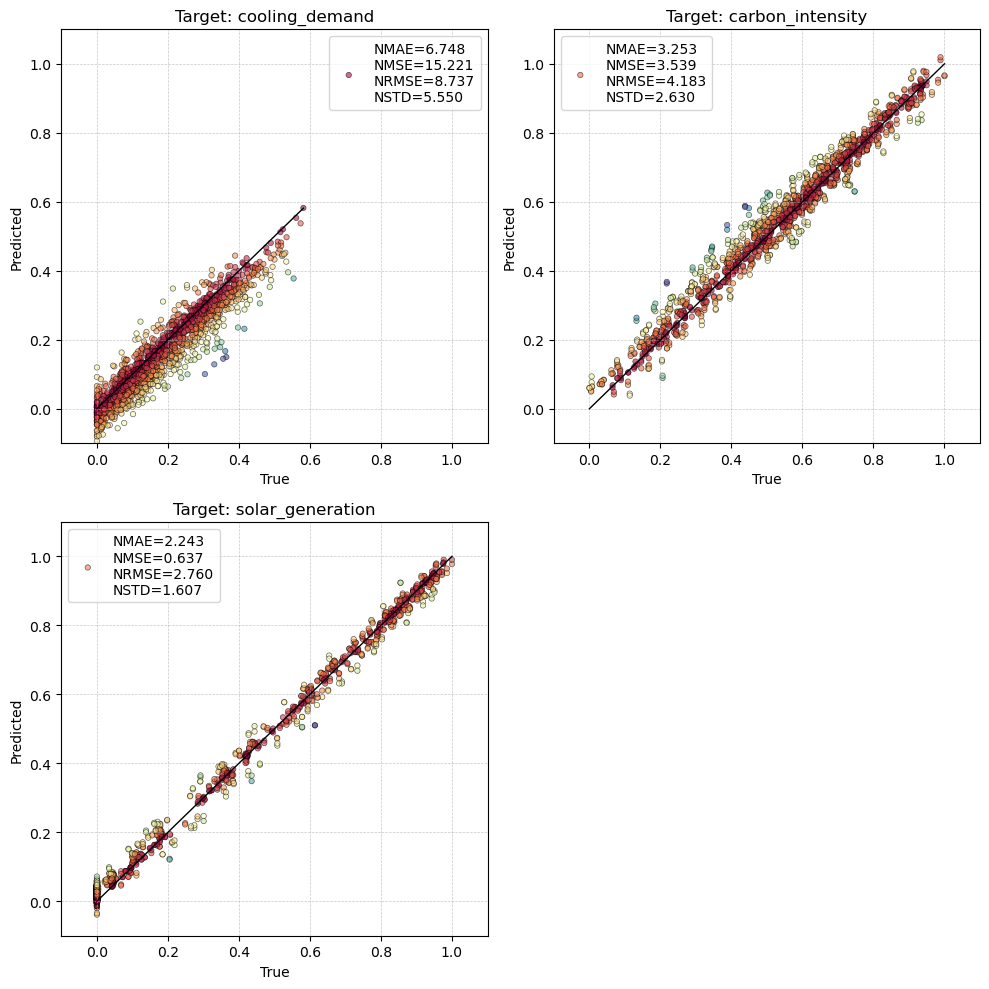

In [10]:
plts.plot_aelstm_targets(real_ael_rfecv, pred_ael_rfecv, targets, selected_features_rfecv, percent=True, filename="autoencoderLSTM_rfecv.png")